In [27]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
#Importing GaussianMixture to use its built-in BIC function.
from sklearn.mixture import GaussianMixture

In [42]:
#dfelectricalUsage = pd.read_csv("daily_electricity_usage 2.csv",parse_dates=thedate)
#dfelectricalUsage.count()

dfElectricalUsage = pd.read_csv('daily_electricity_usage.csv', index_col=1, parse_dates=True)
dfElectricalUsage.head()


,Meter ID,total daily KW
date,,
2009-07-14,1000,11.203
2009-07-15,1000,8.403
2009-07-16,1000,7.225
2009-07-17,1000,11.338
2009-07-18,1000,11.306


## Cleaning data

In [43]:
period = pd.date_range(dfElectricalUsage.index.min(), dfElectricalUsage.index.max()) #Date range from first to last date.

"""
Grouping by Meter ID and applying the specified period to each consumer to fill the missing dates, while filling the missing 
values with the mean of the values for the given Meter ID.
"""
dfElectricalUsage = dfElectricalUsage.groupby('Meter ID').apply(lambda x: x.loc[period].fillna(x.mean()))

"""
The dataframe now has a MultiIndex with date and Meter ID. If we reset the index level it will try to insert Meter ID into
the dataframe. This causes a conflict since Meter ID already is a column. Therefore we drop the column before resetting.
"""
#If we reset index level, it will try to insert Meter ID
dfElectricalUsage = dfElectricalUsage.drop('Meter ID', axis = 1).reset_index(level = 0)
dfElectricalUsage.index.name = 'date'

/Users/funkyapps/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  import sys


In [38]:
#Test for null columns, if any
null_columns=dfElectricalUsage.columns[dfElectricalUsage.isnull().any()]
print(null_columns)
dfElectricalUsage[null_columns].isnull().sum()

print(dfElectricalUsage[dfElectricalUsage["total daily KW"].isnull()][null_columns])
print(dfElectricalUsage[dfElectricalUsage.index.isnull()][null_columns])

#Test any missing dates in the given time period
pd.date_range(start = '2009-07-14', end = '2010-10-17' ).difference(dfElectricalUsage.index)

Index([], dtype='object')
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []


DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [39]:
#dfelectricalUsage.drop_duplicates()   -- there are no duplicates

In [20]:
df = dfElectricalUsage.groupby('Meter ID').nunique()
print("Total # of cunsumers", df.count())

Total # of cunsumers Meter ID          6435
total daily KW    6435
dtype: int64


## Adding calender features to dataset ##

In [32]:
from datetime import date
import calendar
my_date = date.today()
calendar.day_name[my_date.weekday()]

'Thursday'

SyntaxError: invalid syntax (<ipython-input-47-fca7b6629ef8>, line 1)

In [44]:
column_1 = dfElectricalUsage.iloc[:,0]
column_1
#Tried using next line since index_col was changed to 'date'.
#column_1 = dfElectricalUsage.reset_index().set_index('Meter ID').iloc[:,0]
dfElectricalUsage

dfElectricalUsage = pd.DataFrame({"date":dfElectricalUsage.index,
                               "year": dfElectricalUsage.index.year,
                               "month": dfElectricalUsage.index.month,
                               "day": dfElectricalUsage.index.day,
                               "dayofyear": dfElectricalUsage.index.dayofyear,
                               "weekofyear": dfElectricalUsage.index.weekofyear,
                               "weekday": dfElectricalUsage.index.weekday,
                               "weekend": ((pd.DatetimeIndex(dfElectricalUsage.index).dayofweek) // 5 == 1).astype(int),   #integer division to get the weekends
                               "quarter": dfElectricalUsage.index.quarter,
                               "DailyUsage": dfElectricalUsage['total daily KW'],
                               "Meter ID": dfElectricalUsage['Meter ID']})

print(dfElectricalUsage)

                 date  year  month  day  dayofyear  weekofyear  weekday  \
date                                                                      
2009-07-14 2009-07-14  2009      7   14        195          29        1   
2009-07-15 2009-07-15  2009      7   15        196          29        2   
2009-07-16 2009-07-16  2009      7   16        197          29        3   
2009-07-17 2009-07-17  2009      7   17        198          29        4   
2009-07-18 2009-07-18  2009      7   18        199          29        5   
2009-07-19 2009-07-19  2009      7   19        200          29        6   
2009-07-20 2009-07-20  2009      7   20        201          30        0   
2009-07-21 2009-07-21  2009      7   21        202          30        1   
2009-07-22 2009-07-22  2009      7   22        203          30        2   
2009-07-23 2009-07-23  2009      7   23        204          30        3   
2009-07-24 2009-07-24  2009      7   24        205          30        4   
2009-07-25 2009-07-25  20

In [23]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()
holidays = cal.holidays(start='2009-07-14', end='2010-10-17')
dfElectricalUsage['Holiday'] = dfElectricalUsage.index.isin(holidays)
dfElectricalUsageOnlyHoliday = dfElectricalUsage[dfElectricalUsage['Holiday']== True]
print(dfElectricalUsageOnlyHoliday)

                 date  year  month  day  dayofyear  weekofyear  weekday  \
date                                                                      
2009-09-07 2009-09-07  2009      9    7        250          37        0   
2009-10-12 2009-10-12  2009     10   12        285          42        0   
2009-11-11 2009-11-11  2009     11   11        315          46        2   
2009-11-26 2009-11-26  2009     11   26        330          48        3   
2009-12-25 2009-12-25  2009     12   25        359          52        4   
2010-01-01 2010-01-01  2010      1    1          1          53        4   
2010-01-18 2010-01-18  2010      1   18         18           3        0   
2010-02-15 2010-02-15  2010      2   15         46           7        0   
2010-05-31 2010-05-31  2010      5   31        151          22        0   
2010-07-05 2010-07-05  2010      7    5        186          27        0   
2010-09-06 2010-09-06  2010      9    6        249          36        0   
2010-10-11 2010-10-11  20

**Segementation code** 

In [48]:
#daily Average per user
dfElectricalUsage.head()
dfUserGroup = dfElectricalUsage.groupby('Meter ID')['DailyUsage'].mean().reset_index(name='DailyAvgPerUser')

#Quarterly Average per user
qtly_avg_cols = ['Meter ID', 'Q1Avg', 'Q2Avg', 'Q3Avg', 'Q4Avg']
dfUserGroup2 = dfElectricalUsage.groupby(['Meter ID','quarter'])['DailyUsage'].mean().reset_index(name='qtlylyAvg')
dfUserGroup2 = dfUserGroup2.pivot(index = 'Meter ID', columns = 'quarter')['qtlylyAvg'].reset_index()
dfUserGroup2.columns = qtly_avg_cols

# Weekday Average per user
weekday_avg_cols = ['Meter ID', 'MonAvg', 'TueAvg', 'WedAvg', 'ThursAvg','FriAvg','SatAvg','SunAvg']
dfUserGroup3 = dfElectricalUsage.groupby(['Meter ID','weekday'])['DailyUsage'].mean().reset_index(name='weekdayAvg')
dfUserGroup3 = dfUserGroup3.pivot(index = 'Meter ID', columns = 'weekday')['weekdayAvg'].reset_index()
dfUserGroup3.columns = weekday_avg_cols

#Monthly average per user
month_avg_cols = ['Meter ID', 'janAvg', 'febAvg', 'marAvg', 'aprAvg', 'mayAvg', 'junAvg', 'julAvg', 'augAvg', 'sepAvg', 'octAvg', 'novAvg', 'desAvg']
dfUserGroup4 = dfElectricalUsage.groupby(['Meter ID', 'month'])['DailyUsage'].mean().reset_index(name='monthlyAverage')
dfUserGroup4 = dfUserGroup4.pivot(index = 'Meter ID', columns = 'month')['monthlyAverage'].reset_index()
dfUserGroup4.columns = month_avg_cols

#Weekend average
dfWeekendAverage = dfElectricalUsage.groupby(['Meter ID','weekend'])['DailyUsage'].mean().reset_index(name='weekendAvg')



# Merging groups to one dataframe
dfElectricityUsage1 = pd.merge(dfUserGroup,dfUserGroup2,on='Meter ID')
dfElectricityUsage2 = pd.merge(dfElectricityUsage1,dfUserGroup3,on='Meter ID')
dfElectricityUsage3 = pd.merge(dfElectricityUsage2,dfUserGroup4,on='Meter ID')
dfElectricityUsage = pd.merge(dfElectricityUsage3,dfWeekendAverage,on='Meter ID')

dfElectricityUsage


,Meter ID,DailyAvgPerUser,Q1Avg,Q2Avg,Q3Avg,Q4Avg,MonAvg,TueAvg,WedAvg,ThursAvg,...,mayAvg,junAvg,julAvg,augAvg,sepAvg,octAvg,novAvg,desAvg,weekend,WeekendAverage
0,1000,10.290438,12.184656,7.886923,8.704567,12.026440,10.029066,10.493675,10.596247,9.203974,...,7.646516,7.611033,8.431796,8.774016,8.855567,10.584613,11.252267,14.217468,0,10.056042
1,1000,10.290438,12.184656,7.886923,8.704567,12.026440,10.029066,10.493675,10.596247,9.203974,...,7.646516,7.611033,8.431796,8.774016,8.855567,10.584613,11.252267,14.217468,1,10.882599
2,1001,9.496968,6.740656,4.393681,5.030871,17.519630,9.461461,9.494429,9.446922,9.659545,...,4.091355,4.068900,5.050061,4.959355,5.089100,5.178452,11.673000,35.518839,0,9.576417
3,1001,9.496968,6.740656,4.393681,5.030871,17.519630,9.461461,9.494429,9.446922,9.659545,...,4.091355,4.068900,5.050061,4.959355,5.089100,5.178452,11.673000,35.518839,1,9.296257
4,1002,9.986623,11.041756,9.663022,9.457491,10.122315,11.068092,10.070377,11.133766,10.555091,...,10.225839,10.644367,9.943857,9.244500,9.280383,8.675387,11.422967,10.310548,0,10.505617
5,1002,9.986623,11.041756,9.663022,9.457491,10.122315,11.068092,10.070377,11.133766,10.555091,...,10.225839,10.644367,9.943857,9.244500,9.280383,8.675387,11.422967,10.310548,1,8.675480
6,1003,30.420860,34.442156,29.878198,26.478684,32.385957,31.205987,29.749117,30.104987,30.415584,...,32.622774,24.290800,26.464633,25.851242,27.138517,29.507403,32.247150,35.398839,0,30.221945
7,1003,30.420860,34.442156,29.878198,26.478684,32.385957,31.205987,29.749117,30.104987,30.415584,...,32.622774,24.290800,26.464633,25.851242,27.138517,29.507403,32.247150,35.398839,1,30.923382
8,1004,47.250825,45.986500,41.709725,48.071123,49.847337,48.756053,46.630390,47.364740,44.976065,...,45.338000,42.058933,45.918694,47.645984,50.268250,48.738435,49.455483,51.335452,0,46.019776
9,1004,47.250825,45.986500,41.709725,48.071123,49.847337,48.756053,46.630390,47.364740,44.976065,...,45.338000,42.058933,45.918694,47.645984,50.268250,48.738435,49.455483,51.335452,1,50.360842


**K-Means Clustering**


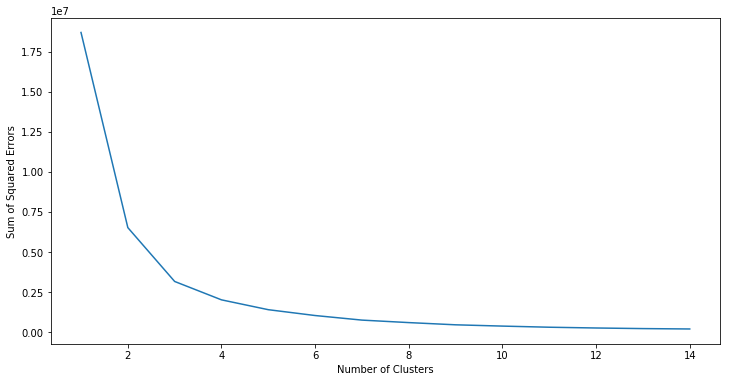

In [37]:
features = dfUserGroup.iloc[:, 1:]

SSE = {}
for k in range(1, 15):
    model = KMeans(n_clusters = k).fit(features)
    #features["clusters"] = model.labels_
    SSE[k] = model.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    
plt.figure(figsize = (12,6))
plt.plot(list(SSE.keys()), list(SSE.values()))
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Errors")
plt.show()

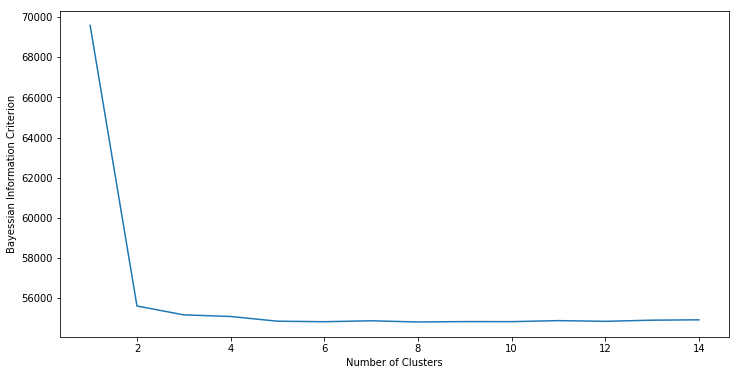

In [38]:
BIC = {}

for k in range(1, 15):
    model = GaussianMixture(n_components = k, init_params = 'kmeans').fit(features)
    BIC[k] = model.bic(features)

plt.figure(figsize = (12,6))
plt.plot(list(BIC.keys()), list(BIC.values()))
plt.xlabel("Number of Clusters")
plt.ylabel("Bayessian Information Criterion")
plt.show()

In [39]:
k_means = KMeans(n_clusters = 3).fit(features) #Using 3 clusters, change this after adding more features.
features['Cluster'] = k_means.fit_predict(features)
print(features.head())
features.Cluster.value_counts()


   DailyAvgPerUser  Cluster
0        10.290438        0
1         9.496968        0
2         9.986623        0
3        30.420860        0
4        47.250825        0


0    6155
2     242
1      38
Name: Cluster, dtype: int64